In [7]:
import numpy as np
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt

In [8]:
def calculate_profiles(image_array):
    profile_x = np.sum(image_array == 0, axis=0)
    profile_y = np.sum(image_array == 0, axis=1)
    return profile_x, profile_y


In [9]:
def save_profiles_and_character(profile_x, profile_y, char_image, title, profile_folder, filename):
    plt.figure(figsize=(15, 10))

    # Символ
    plt.subplot(3, 1, 1)
    plt.imshow(char_image, cmap='gray')
    plt.title(f'{title} - Character')
    plt.axis('off')

    # Профиль X
    plt.subplot(3, 1, 2)
    plt.bar(range(len(profile_x)), profile_x, color='black')
    plt.title(f'{title} - Profile X')
    plt.xlabel('Index')
    plt.ylabel('Sum of Black Pixels')

    # Профиль Y (развернут на 180 градусов)
    plt.subplot(3, 1, 3)
    plt.barh(range(len(profile_y)), profile_y[::-1], color='black')
    plt.title(f'{title} - Profile Y')
    plt.ylabel('Index')
    plt.xlabel('Sum of Black Pixels')

    plt.tight_layout()
    profile_path = os.path.join(profile_folder, filename)
    plt.savefig(profile_path)
    plt.close()


In [18]:
def segment_lines(image_array):
    profile_y = np.sum(image_array == 0, axis=1)
    segments = []

    in_segment = False
    start = 0

    for i, value in enumerate(profile_y):
        if value > 0 and not in_segment:
            in_segment = True
            start = i
        elif value == 0 and in_segment:
            in_segment = False
            end = i
            segments.append((start, end))

    if in_segment:
        segments.append((start, len(profile_y)))

    return segments

def segment_characters(image_array):
    profile_x, _ = calculate_profiles(image_array)
    segments = []

    in_segment = False
    start = 0

    for i, value in enumerate(profile_x):
        if value > 0 and not in_segment:
            in_segment = True
            start = i
        elif value == 0 and in_segment:
            in_segment = False
            end = i
            segments.append((start, end))

    if in_segment:
        segments.append((start, len(profile_x)))

    return segments

def draw_bounding_boxes(image_path, segments, output_path, profile_folder):
    image = Image.open(image_path).convert('L')
    draw = ImageDraw.Draw(image)
    char_count = 0

    for line_start, line_end in segments:
        line_image = image.crop((0, line_start, image.width, line_end))
        line_array = np.array(line_image)
        char_segments = segment_characters(line_array)
        
        for char_start, char_end in char_segments:
            box = [char_start, line_start, char_end, line_end]
            draw.rectangle(box, outline="red")

            # Сохранение каждого символа отдельно
            char_image = image.crop((char_start, line_start, char_end, line_end))
            char_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_char_{char_count}.png"
            char_path = os.path.join(profile_folder, char_filename)
            char_image.save(char_path)

            # Сохранение профилей и символа каждого сегмента
            char_array = np.array(char_image)
            profile_x, profile_y = calculate_profiles(char_array)
            profile_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{char_count}_profiles.png"
            save_profiles_and_character(profile_x, profile_y, char_array, f"Character {char_count}", profile_folder, profile_filename)

            char_count += 1

    image.save(output_path)
    print(f"Saved image with bounding boxes to {output_path}")




In [19]:
def process_images_in_folder(folder_path, profile_folder):
    if not os.path.exists(profile_folder):
        os.makedirs(profile_folder)

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            file_path = os.path.join(folder_path, filename)
            image = Image.open(file_path).convert('L')
            image_array = np.array(image)

            profile_x, profile_y = calculate_profiles(image_array)

            # Визуализация исходного изображения и профилей
            plt.figure(figsize=(15, 10))

            # Исходное изображение
            plt.subplot(2, 2, 1)
            plt.imshow(image_array, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            # Профиль X
            plt.subplot(2, 2, 3)
            plt.bar(range(len(profile_x)), profile_x, color='black')
            plt.title('Horizontal Profile')
            plt.xlabel('Column Index')
            plt.ylabel('Sum of Black Pixels')

            # Профиль Y
            plt.subplot(2, 2, 4)
            plt.barh(range(len(profile_y)), profile_y[::-1], color='black')
            plt.title('Vertical Profile')
            plt.ylabel('Row Index')
            plt.xlabel('Sum of Black Pixels')

            plt.tight_layout()
            plt.show()

            # Сегментация строк
            line_segments = segment_lines(image_array)

            bounding_boxes_path = os.path.join(profile_folder, f"{os.path.splitext(filename)[0]}_bounding_boxes.png")
            draw_bounding_boxes(file_path, line_segments, bounding_boxes_path, profile_folder)


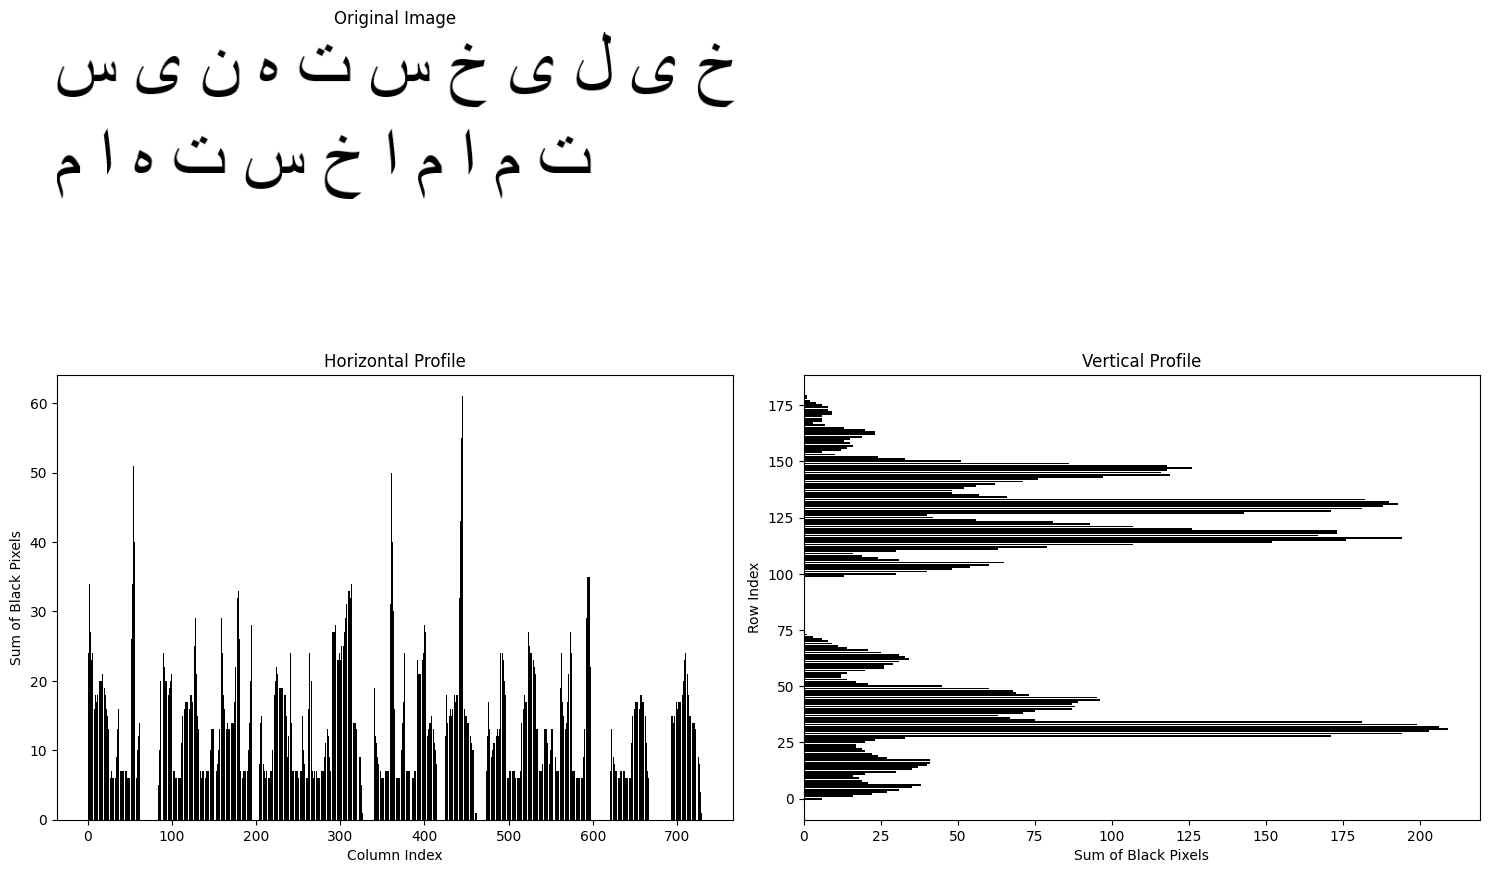

Saved image with bounding boxes to output\string_bounding_boxes.png


In [20]:
folder_path = 'input'
# Папка для сохранения изображений с обрамляющими прямоугольниками
profile_folder = 'output'

# Вызываем функцию обработки изображений
process_images_in_folder(folder_path, profile_folder)